In [339]:
%pip install qiskit qiskit_aer pylatexenc
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np


## Steane's 7-qubit code


In this notebook we recall fundamentals about stabilizer codes and work through encoding $|0_L\rangle$ for Steane's $[[7,1,3]]$ code, introduce random Pauli error, and implement a circuit which detects syndromes and fixes them.

In [340]:
# Declare your input:
### n is the dimension of the original message to be transmitted.
### However, we will cap it at n = 1 as one can re-run Steane's code per qubit independently.
# n = 1

# P is the probability of independently adding an X, Y or Z error, independently per Qubit
P = 0.09

## Preliminaries on Stabilizer Codes

Let $n\in \mathbb{N}$. A CSS code is defined as the fixed space, or intersection of the +1 eigenspace for elements in a *stabilizer group* $S$, which is an abelian subgroup of the Pauli group $P_n$ that does not contain $-I\otimes I\otimes \dots \otimes I$. Given a stabilizer group $S$, define the associated stabilizer code to be
$$
C(S)
=
\{|\psi\rangle\in (\mathbb{C}^2)^{\otimes n}:P|\psi\rangle=|\psi\rangle\,\,\forall P\in S\}.
$$
By virtue of a stabilizer group's defining properties, we can simplify the definition of $C(S)$ as the following: given a generating set $\{g_i\}_{i=1}^m$ of $S$, the stabilizer code is
$$
C(S)
=
\{|\psi\rangle\in (\mathbb{C}^2)^{\otimes n}:g_i |\psi\rangle=|\psi\rangle\,\,\forall i\in [m]\}.
$$
Let $\alpha = i_0i_1\dots i_{n-1}$ be an $n$-bit string (so $i_k\in \{0,1\}$ for all $k$), and for $P\in \{X,Y,Z\}$, define $P_\alpha:= \otimes_{k=0}^{n} i_k P$.

Given $\{0,1\}$-matrices $H_X$ and $H_Z$, known as *check matrices*, of dimension $m\times n$ which satisfy $H_XH_Z^T=0$, we can recover generators $\{X_\alpha,Z_\beta:\alpha\in \text{Row}(H_X),\beta\in \text{Row}(H_Z)\}$, where $\text{Row}(A)$ denotes the row space of a matrix $A$.

## Steane's Code

Consider the check matrices
$$
H_X=H_Z
=
\begin{bmatrix} 1&1&1&1&0&0&0 \\ 1&1&0&0&1&1&0 \\ 1&0&1&0&1&0&1 \end{bmatrix}
$$
which give rise to the stabilizer group $S$ generated by $$\{X_{1111000},X_{1100110},X_{1010101},Z_{1111000},Z_{1100110},Z_{1010101}\}.$$ The code $C(S)$ is called *Steane's Code*.

In [341]:
### We denote both H_X and H_Z by H for Steane's Code.

H = np.array([[1, 1, 1, 1, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0],
              [1, 0, 1, 0, 1, 0, 1]])

print(np.array_equal((H@(H.T))%2, np.zeros((3, 3), dtype=int)))

True


### Possible $X$ syndromes:

$H$ has a pseudo inverse that helps us to decode. below is the syndrome to $X$ error recipe (same for $Z$ due to self-duality):

\begin{align}
    \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}   \mapsto X_0, \qquad
    \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}   \mapsto X_1, \qquad
    \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix}   \mapsto X_2, \qquad
    \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}   \mapsto X_3, \qquad
    \begin{pmatrix} 0 \\ 1 \\ 1 \end{pmatrix}   \mapsto X_4, \qquad
    \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}   \mapsto X_5, \qquad
    \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}   \mapsto X_6,
\end{align}



### Encoder for Steane's code for single qubit

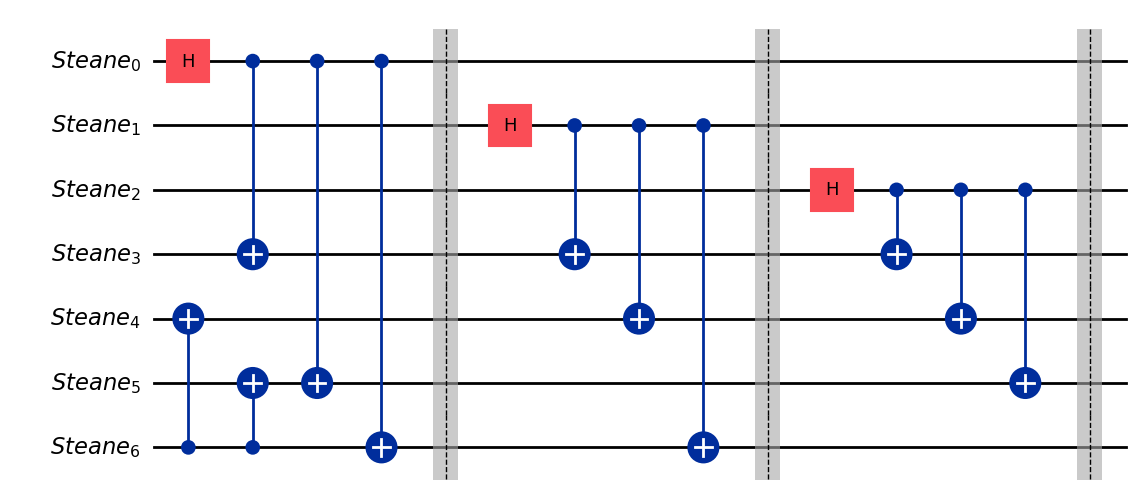

In [342]:
### Encoder taken from https://abdullahkhalid.com/qecft/stabilizer-codes/encoding-circuits-for-stabilizer-codes/
qubits_for_steane = QuantumRegister(size=7, name="Steane")
steane_code = QuantumCircuit(qubits_for_steane, name="Steane circuit")

steane_code.h(0)
steane_code.cx(qubits_for_steane[6],qubits_for_steane[4])
steane_code.cx(qubits_for_steane[6],qubits_for_steane[5])
steane_code.cx(qubits_for_steane[0],qubits_for_steane[3])
steane_code.cx(qubits_for_steane[0],qubits_for_steane[5])
steane_code.cx(qubits_for_steane[0],qubits_for_steane[6])
steane_code.barrier()
steane_code.h(1)
steane_code.cx(qubits_for_steane[1],qubits_for_steane[3])
steane_code.cx(qubits_for_steane[1],qubits_for_steane[4])
steane_code.cx(qubits_for_steane[1],qubits_for_steane[6])
steane_code.barrier()
steane_code.h(2)
steane_code.cx(qubits_for_steane[2],qubits_for_steane[3])
steane_code.cx(qubits_for_steane[2],qubits_for_steane[4])
steane_code.cx(qubits_for_steane[2],qubits_for_steane[5])
steane_code.barrier()


steane_code.draw(output = 'mpl')

In [343]:
### To check Encoder appropriately encodes $|0\rangle$
Statevector(steane_code).draw("Latex")

<IPython.core.display.Latex object>

Our encoded 7-qubit state $|0_L\rangle$ consists of a uniform distribution (0.125) of eight basis vectors:
$$
|0000000 \rangle
\quad
| 0001111\rangle
\quad
| 0110011\rangle
\quad
| 0111100\rangle
\quad
|1010101 \rangle
\quad
| 1011010\rangle
\quad
| 1100110\rangle
\quad
| 1101001 \rangle
$$ Next, we introduce error to simulate a noisy quantum channel.

## Simulating error from a noisy quantum channel

Suppose our transmitted code $|0_L\rangle$ ends up with some error, such as a single bit flip, or, more generally, a Pauli error on a single qubit.

In [344]:
### Single qubit flip

#steane_code.x(3) #choose your qubit out of 0,1,2,3,4,5,6

### Observe how the state vector displays the bit flip


In [345]:
#Statevector(steane_code).draw("Latex")

### Random Pauli noise
For each qubit, with probability $p\leq 1/3$ we independently add $X$, $Y$ or $Z$ errors.

loc= 0 aux= [0 0 0]
loc= 1 aux= [0 0 0]
loc= 2 aux= [0 0 0]
loc= 3 aux= [1 0 0]
loc= 4 aux= [0 0 0]
loc= 5 aux= [0 0 0]
loc= 6 aux= [0 0 0]


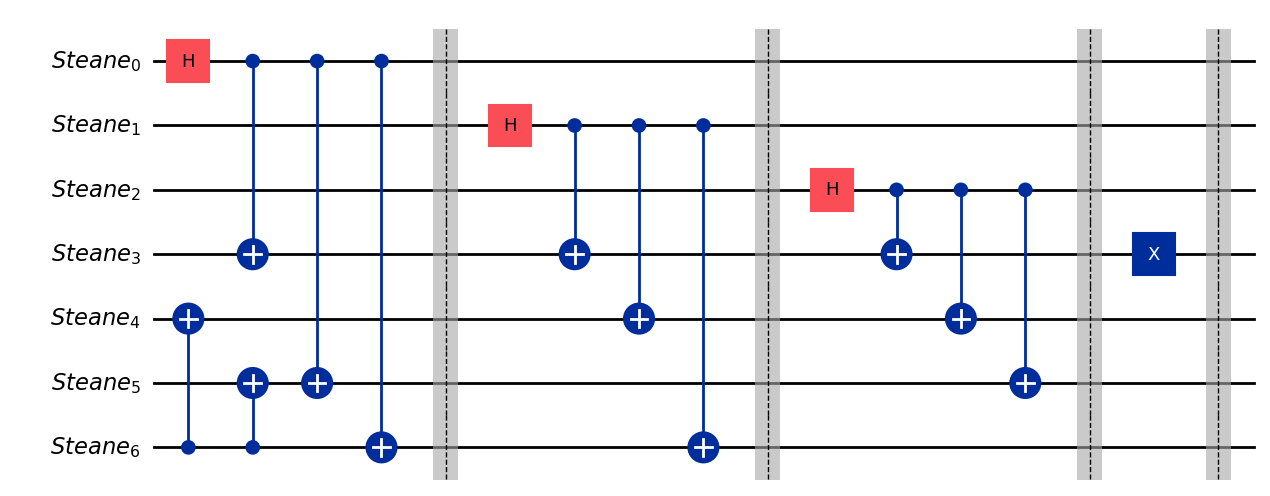

In [346]:
### Don't run this window if you have already chosen to add noise at your will.

# add a random X, Y, Z Error independently per qubit
aux=0

for loc in range(7):
    aux = np.random.binomial(size=3, n=1, p=P) # This is a Bernouli random variable with probability p
    print('loc=', loc, 'aux=', aux)
    if aux[0] == 1:
        steane_code.x(qubits_for_steane[loc])
    if aux[1] == 1:
        steane_code.y(qubits_for_steane[loc])
    if aux[2] == 1:
        steane_code.z(qubits_for_steane[loc])

steane_code.barrier()
steane_code.draw(output="mpl")

In [347]:
Statevector(steane_code).draw("Latex")
### Note: Reading register from bottom to top yields computational basis vectors read from left to right

<IPython.core.display.Latex object>

### Syndrome Detection:

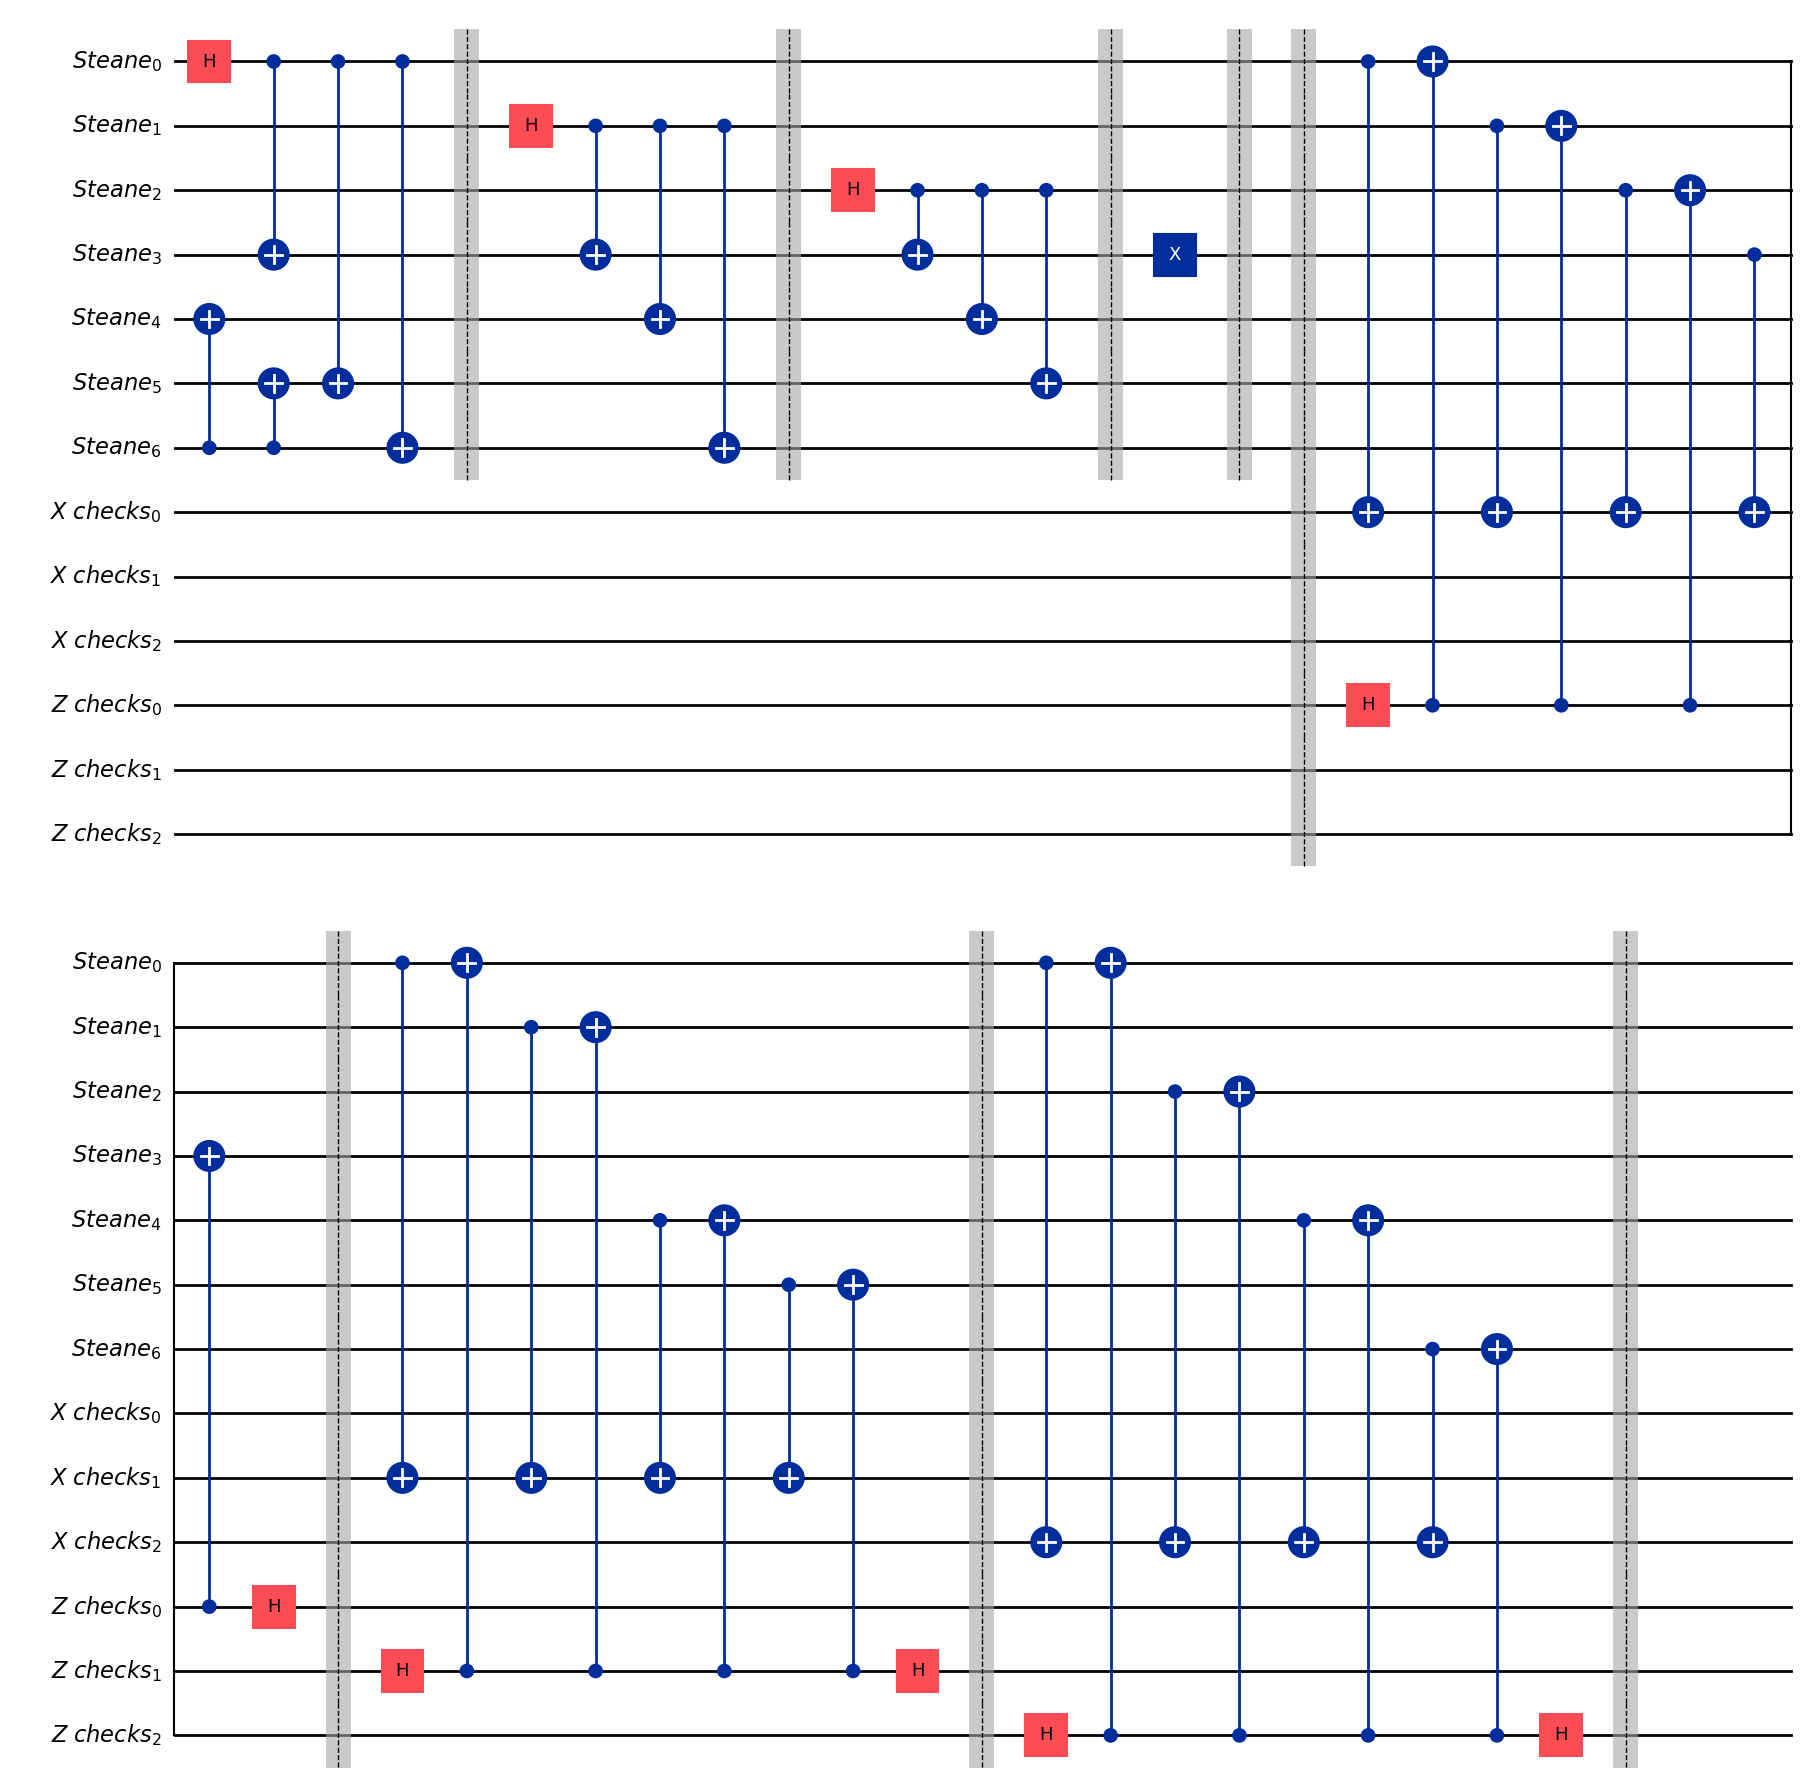

In [348]:
# Adding ancillas for syndromes
qubits_for_X_checks = AncillaRegister(size=3, name=f"X checks")
qubits_for_Z_checks = AncillaRegister(size=3, name=f"Z checks")
### Is it not necessary to add another layer to correct Y errors since
### XZ = -ZX = iY, the X and Z correction will take care of it as is.

steane_code.add_register(qubits_for_X_checks, qubits_for_Z_checks)
steane_code.barrier()

# Extracting sydromes
for idx, row in enumerate(H):
    steane_code.h(qubits_for_Z_checks[idx])
    for qubit in np.where(row)[0]:
        steane_code.cx(qubit, qubits_for_X_checks[idx]) # X check
        steane_code.cx(qubits_for_Z_checks[idx], qubit) # Z check

    steane_code.h(qubits_for_Z_checks[idx])
    steane_code.barrier()

steane_code.draw(output="mpl")

In [349]:
#Note first 3 bits: Z-checks, second 3 bits: Xchecks, last 7 bits: corrupted codeword:
Statevector(steane_code).draw("Latex")

<IPython.core.display.Latex object>

### Syndrome measurement

In [350]:
### Add classical bits for storing syndromes

X_syndromes = ClassicalRegister(3, name="s_X")
Z_syndromes = ClassicalRegister(3, name="s_Z")
steane_code.add_register(X_syndromes, Z_syndromes)


### Measure

steane_code.measure(qubits_for_X_checks, X_syndromes)
steane_code.measure(qubits_for_Z_checks, Z_syndromes)

#steane_code.draw(output="mpl")

### Applying THE necessary recovery operations

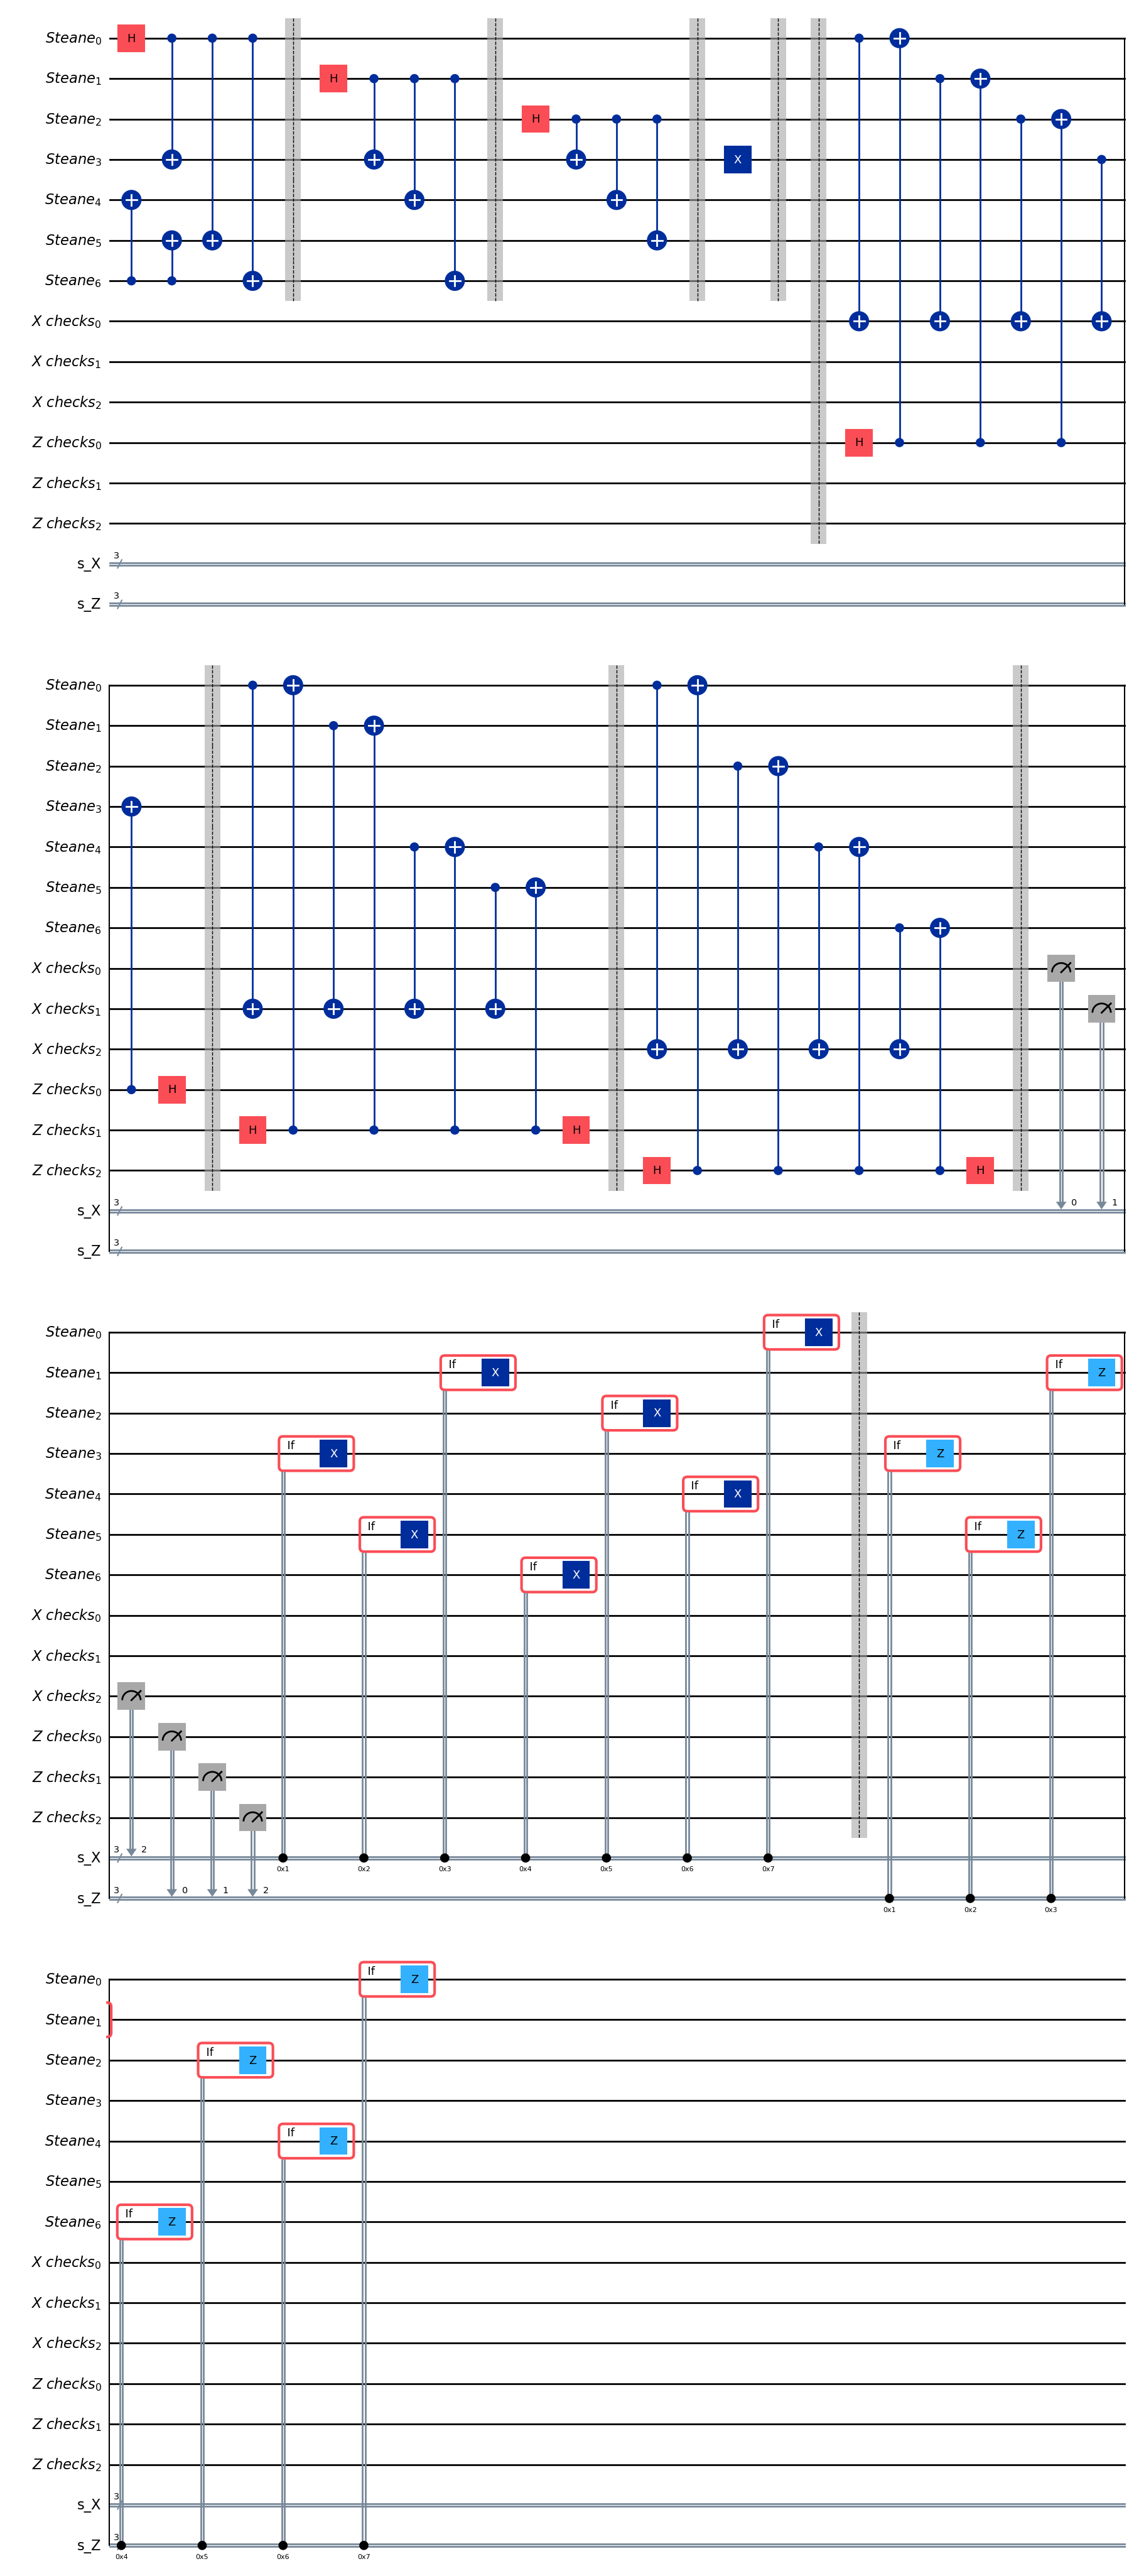

In [351]:
###                                           ### Some statistical data recorded for demonstration purposes (why our syndrome correction is correct)
### Adding the X checks
with steane_code.if_test((X_syndromes, 1)):   ### Corresponds to X3 or X6 error   ### Confirmed
    steane_code.x(qubits_for_steane[3])       ###  Qubit 3 & NOT Qubit 5          ### 16% vs 0% success rate

with steane_code.if_test((X_syndromes, 2)):
    steane_code.x(qubits_for_steane[5])                                          ### 11% and 17% success rate in indep trials

with steane_code.if_test((X_syndromes, 3)):   ### Corresponds to X1 or X4 error  ### Confirmed
    steane_code.x(qubits_for_steane[1])       ### Qubit 1 & NOT Qubit 4          ### 16% vs 0% success rate

with steane_code.if_test((X_syndromes, 4)):   ### Corresponds to X3 or X6 error  ###
    steane_code.x(qubits_for_steane[6])       ###                                ### 10% success rate

with steane_code.if_test((X_syndromes, 5)):
    steane_code.x(qubits_for_steane[2])                                          ### 16%, 18%, 11% success rate

with steane_code.if_test((X_syndromes, 6)):                                       ### Confirmed
    steane_code.x(qubits_for_steane[4])                                           ### 17% success rate

with steane_code.if_test((X_syndromes, 7)):     ### Corresponds to X0 error       ### Confirmed:
    steane_code.x(qubits_for_steane[0])         ### qubit 0 & NOT qubit 6         ###19% vs 0% success rate respectively

steane_code.barrier()

### Adding the Z checks
with steane_code.if_test((Z_syndromes, 1)):
    steane_code.z(qubits_for_steane[3])

with steane_code.if_test((Z_syndromes, 2)):
    steane_code.z(qubits_for_steane[5])

with steane_code.if_test((Z_syndromes, 3)):
    steane_code.z(qubits_for_steane[1])

with steane_code.if_test((Z_syndromes, 4)):
    steane_code.z(qubits_for_steane[6])

with steane_code.if_test((Z_syndromes, 5)):
    steane_code.z(qubits_for_steane[2])

with steane_code.if_test((Z_syndromes, 6)):
    steane_code.z(qubits_for_steane[4])

with steane_code.if_test((Z_syndromes, 7)):
    steane_code.z(qubits_for_steane[0])


steane_code.draw(output="mpl")

 ### Measuring the data qubits

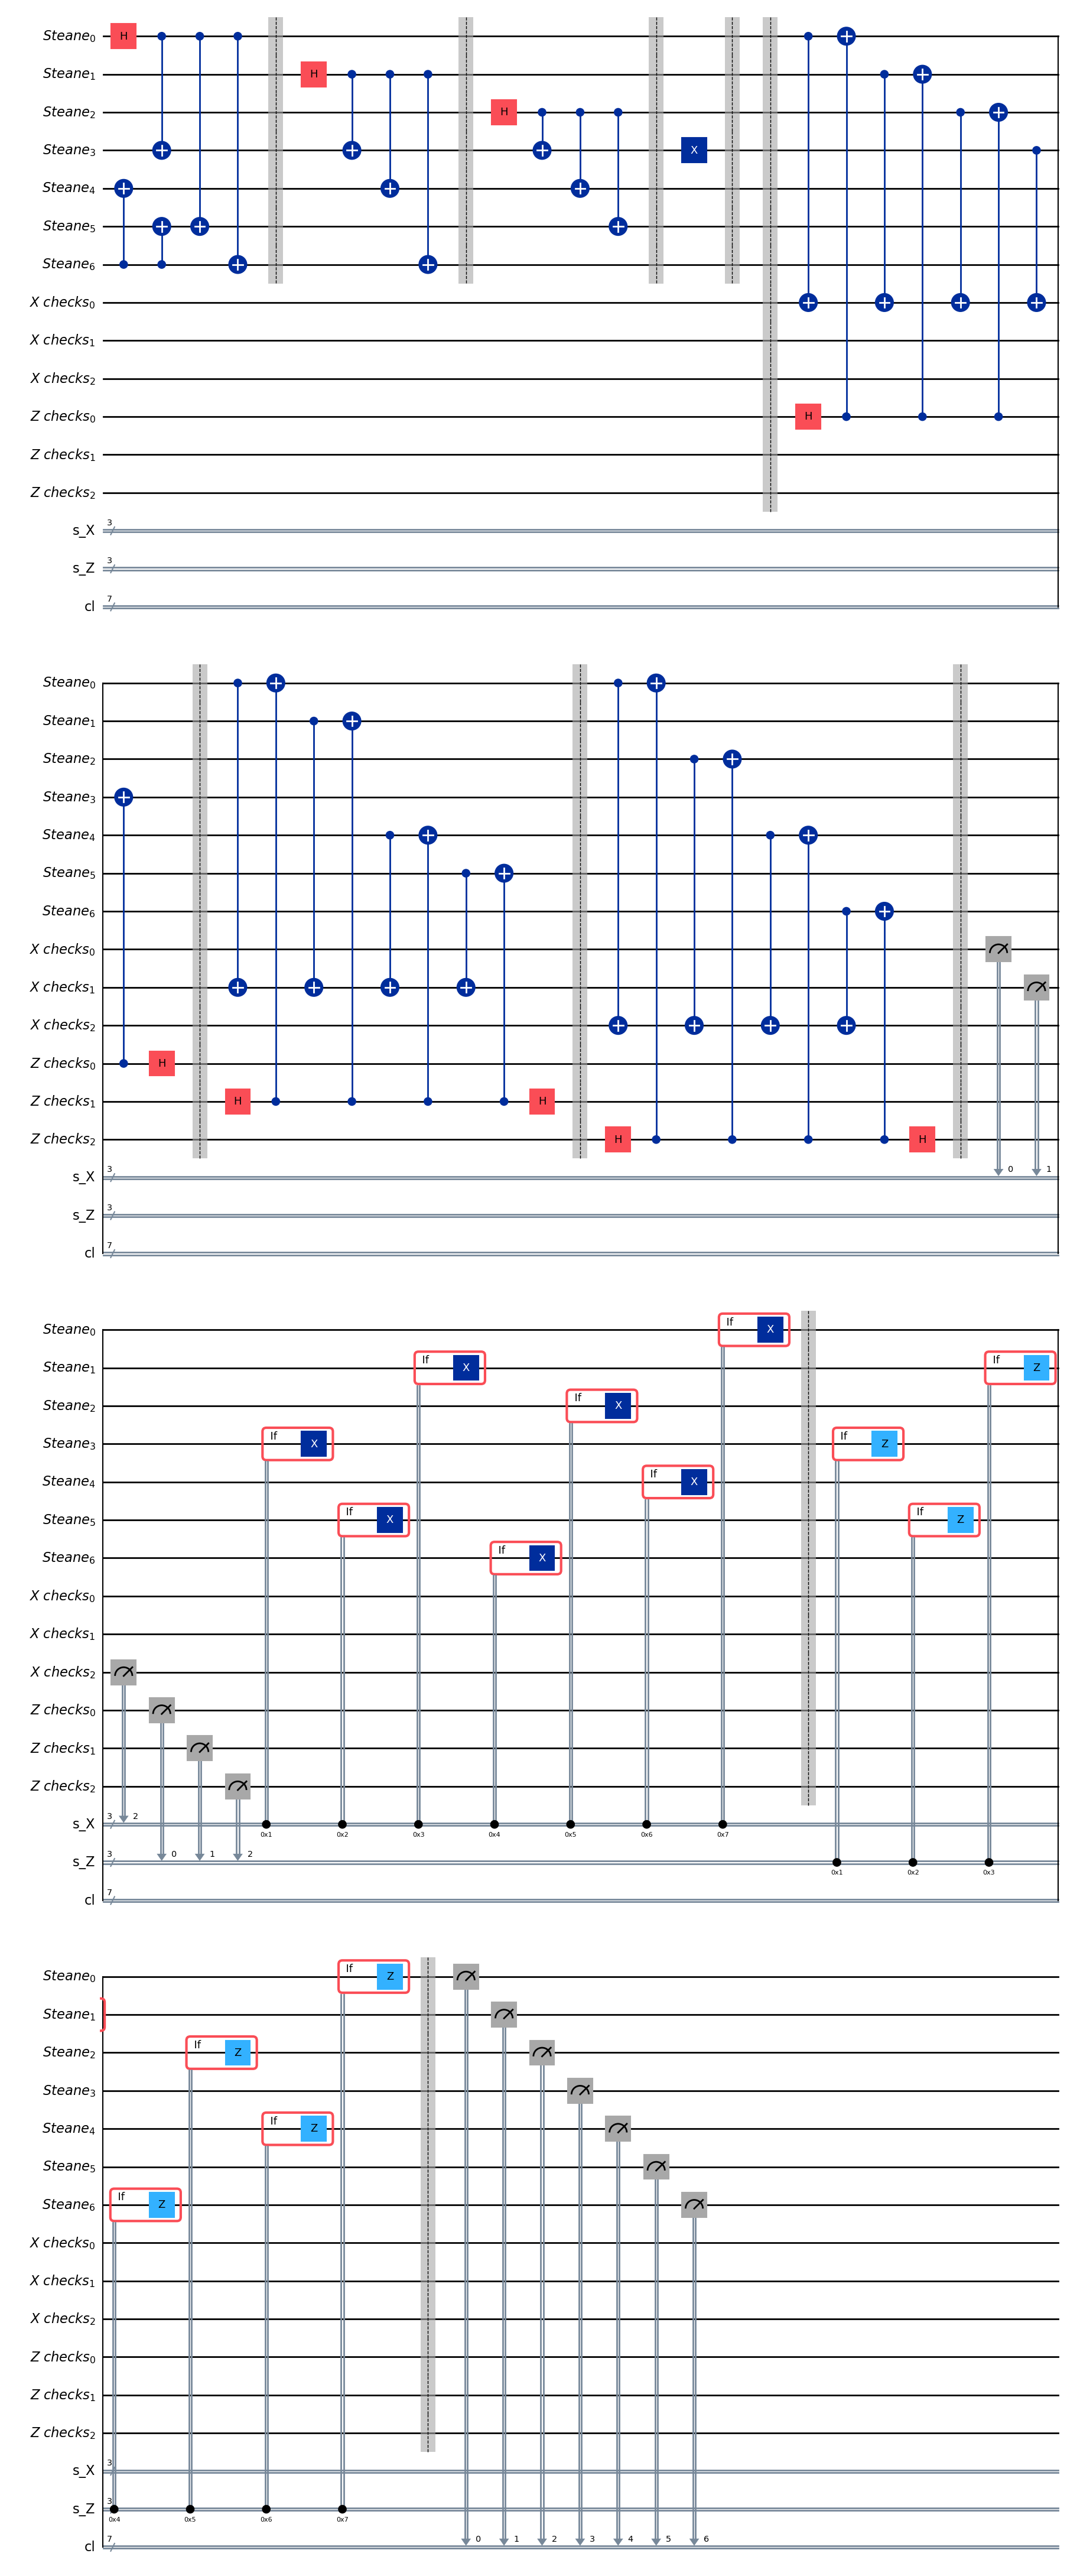

In [352]:
# Adding classical bits for data
qubit_measurements = ClassicalRegister(7, name=f"cl")
steane_code.add_register(qubit_measurements)

steane_code.barrier()
# Measuring
steane_code.measure(qubits_for_steane, qubit_measurements)

steane_code.draw(output="mpl")

### Decoding the result

In [353]:
simulator = AerSimulator()

In [354]:
rounds = 100
# Transpile the circuit for the backend
compiled_circuit = transpile(steane_code, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

In [355]:
distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution

{'0000000': 0.1,
 '1011010': 0.08,
 '1100110': 0.12,
 '1010101': 0.14,
 '1101001': 0.15,
 '0001111': 0.12,
 '0111100': 0.11,
 '0110011': 0.18}

### Conclusion

Recall $|0_L\rangle$ for our code is
$$
 \frac{\sqrt{2}}{4}\left(|0000000\rangle+
 ∣0001111⟩+
 ∣0110011⟩+
 ∣0111100⟩+
 ∣1010101⟩+
 ∣1011010⟩+
 ∣1100110⟩+
 ∣1101001⟩\right)
 $$
Given a (possibly incorrectly) corrected $|\tilde{0_L}\rangle$, the *success probabilty* is defined to be the probabilty that you measure a component of the logical all-zero state at the end.

**Example 1**: When our random Pauli error consisted of one X and one Z on different qubits with probability $p$ for each, we obtain a state which, although not in uniform distribution of the original eight computational basis vectors for $|0L\rangle$, was in superposition with precisely those eight basis vectors. In this case, the success probability was 100%.

As we varied $p$, we noticed that, in fact, the probability amplitudes of those eight basis vectors stayed within $p$ of $0.125$, the probability amplitude for each of the eight basis vectors for $|0_L\rangle$.

**Example 2**: When our random Pauli error consisted of two X errors on different qubits, our success probability went way down. For p = 0.05, we had the following final measurement:

\begin{align*}
\text{Basis vector} \quad &\quad \text{Probability amplitude} \\ \hline
0100101 \quad & \quad 0.16 \\
1111111 \quad & \quad 0.12 \\
1110000 \quad & \quad 0.12 \\
0011001 \quad & \quad 0.10 \\
1001100 \quad & \quad 0.16\\
0010110 \quad & \quad 0.10 \\
1000011 \quad & \quad 0.12\\
0101010 \quad & \quad 0.12\\
\end{align*}

 None of the above basis vectors coincide with the original eight appearing in $|0_L\rangle$, so our success probability is 0%.

 **Example 3**: When our random Pauli error contained two $Y$ errors on different qubits (in addition to a $Z$ error on a third qubit), we again had no basis vectors in common with the $|0_L\rangle$ state, so our success probability is 0%.

